In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
pd.set_option('display.width', 100)
pd.set_option('precision', 3)

In [1]:
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error, r2_score
from linearmodels import PanelOLS

class linear_regression:
    def __init__(self):
        self.reg = None
    
    def ols_fit(self, X, y, add_const=True, plot=None, assumption_test=False, if_print=True):
        """
        plot: column name of X that want to plot
        """
        if add_const:
            X_ = sm.add_constant(X)
        mod = sm.OLS(y.values, np.asarray(X_))
        res = mod.fit()        
        #print(res.summary())
        res = res.get_robustcov_results()
        self.reg = res
        if if_print:
            print(res.summary()) # Robusted Results
        
        if plot is not None:
            prstd, iv_l, iv_u = wls_prediction_std(self.reg)
            plt.figure(figsize=(10,6))
            plt.plot(X[plot], y, 'o', label='Sample Data')
            fit_data = pd.DataFrame({'X': X[plot],
                                     'y': res.fittedvalues,
                                    'upper': iv_u,
                                    'lower': iv_l})
            fit_data.sort_values(by='X', inplace=True)
            plt.plot(fit_data.X, fit_data.y, 'r', label='OLS model')
            plt.plot(fit_data.X, fit_data.upper, color='darksalmon', ls='--')
            plt.plot(fit_data.X, fit_data.lower, color='darksalmon', ls='--')
            plt.legend(loc='best')
            plt.show()
            
        if assumption_test:
            error = res.fittedvalues - y
            print('Residual Tests:')
            # Durbin-Waston test: 
            dw = durbin_watson(error)
            print('DW test statistic: ', dw)
            print('(2: no serial correlation; 0: positive serial correlation; 4: negative serial correlation)')
            
            sm.graphics.tsa.plot_acf(error, lags=20) # residual auto-correlation
            
            sm.qqplot(error, loc = error.mean(), scale = error.std(), line='s') # residual normality
            
    def gls_fit(self, X, y, add_const=True):
        if add_const:
            X_ = sm.add_constant(X)
        mod = sm.GLS(y.values, np.asarray(X_))
        res = mod.fit()        
        #print(res.summary())
        res = res.get_robustcov_results()
        self.reg = res
        print(res.summary()) # Robusted Results
    
    def get_predict(self, X_test, add_const=True):
        if add_const:
            X_test = sm.add_constant(X_test)
        return self.reg.predict(X_test)
    
    def test_performance(self, X_test, y_test, add_const=True, plot=None):
        y_pred = self.get_predict(X_test, add_const=add_const)
        print("Mean squared error: %.2f"% mean_squared_error(y_test, y_pred))
        # Explained variance score: 1 is perfect prediction
        print('R-2 score: %.2f' % r2_score(y_test, y_pred))
        
        if plot is not None:
            plt.figure(figsize=(10,6))
            plt.scatter(X_test[plot], y_test, color='black', label='Test Sample Data')
            fit_data = pd.DataFrame({'X': X_test[plot],
                                     'y': y_pred})
            fit_data.sort_values(by='X', inplace=True)
            plt.plot(fit_data.X, fit_data.y, color='blue',label='Model Value', linewidth=3)
            plt.legend(loc='best')
            plt.show()
        
    def get_parameters(self, pr=True):
        """
        get parameters, standard errors, t-values, p-values
        """
        if pr:
            print('Coeficients: ', self.reg.params)
            print('Standard error: ', self.reg.bse)
            print('T-values: ', self.reg.tvalues) 
            print('p-values: ', self.reg.pvalues) 
        return self.reg.params, self.reg.bse, self.reg.tvalues, self.reg.pvalues
    
    def get_confidence_intervals(self, alpha=0.05):
        return self.reg.conf_int(alpha=alpha)
    
    def print_latex(self):
        return self.reg.summary().as_latex()
    
    def get_residuals(self, normalize=False):
        """
        normalize: Default False, return normalized residuals to have unit variance if True
        """
        if normalize:
            return self.reg.resid_pearson
        else:
            return self.reg.resid
    
    def get_r_square(self):
        """
        return R2 and Adj-R2
        """
        return self.reg.rsquared, self.reg.rsquared_adj
        
    def panel_regression(self, X, y, entity_col, time_col, entity_effects=False, time_effects=False, other_effects=None, add_const=True, drop_absorbed=True):
        """
        other_effects (array-like) – Category codes to use for any effects that are not entity or time effects. Each variable is treated as an effect
        return fitted res
        """

        X = X.set_index([entity_col, time_col])
        y.index = X.index
        if add_const:
            X = sm.add_constant(X)
        if other_effects is None:
            mod = PanelOLS(y, X, entity_effects=entity_effects, time_effects=time_effects)#, endog_names=['intercept'] + X.columns)
        else:
            mod = PanelOLS(y, X, entity_effects=entity_effects, time_effects=time_effects, other_effects=X[other_effects])
        res = mod.fit()
        print(res.summary)
        return res
       
    def glm_regression(self, X, y, mod_family, add_const=True):
        """
        mod_family: sm.families.Binomial([link]), Gamma(), Gaussian(),InverseGaussian(), NegativeBinomial(), Poisson(), Tweedie()
        link: CDFlink, CLogLog, Log, Logit, NegativeBinomial([alpha]), Power([power]), cauthy(), cloglog, identity(), inverse_power(), inverse_sqared(), log, logit, nbinom([alphal]), probit([dbn])
        return fitted res
        """
        if add_const:
            X = sm.add_constant(X)
        mod = sm.GLM(y, X, family=mod_family)
        res = mod.fit()
        print(res.summary())
        return res

In [16]:
import statsmodels.api as sm
from scipy.special import expit

class logistic_regression:
    def __init__(self):
        self.reg = None
        
    def fit(self, X, y, add_const=True, plot=None, method='bfgs', if_print=True):
        """
        print summary table, prediction table (pred_table[i,j] refers to the number of times “i” was observed and the model predicted “j”. Correct predictions are along the diagonal.)
        """
        if add_const:
            X_ = sm.add_constant(X)
        mod = sm.Logit(y, X_)
        res = mod.fit(method=method)
        self.reg = res
        if if_print:
            print(res.summary())
            print('Prediction Table:')
            print(pd.DataFrame(res.pred_table()))
        
        if plot is not None:
            plt.clf()
            plt.figure(figsize=(10,6))
            plt.scatter(X[y == 1][plot], y[y == 1], color='r',label='Positive Sample', zorder=1)
            plt.scatter(X[y == 0][plot], y[y == 0], color='b',label='Negative Sample', zorder=1)
            X_ = X_.sort_values(by=plot)
            logit = expit(np.dot(X_, res.params))
            plt.plot(X_[plot], logit, 'k--',label='Fitted Model', linewidth=1)
            plt.legend(loc='best')
            plt.show()            
            
    def get_predict(self, X_test, add_const=True):
        if add_const:
            X_test_ = sm.add_constant(X_test)       
        return self.reg.predict(X_test_) 
        
    def test_performance(self, X_test, y_test, plot=None, add_const=True):
        """
        print out precision, accuracy, recall, f1
        """
        y_pred = self.get_predict(X_test, add_const=add_const)
        tp = np.count_nonzero(np.all([y_pred == 1, y_test == 1], axis=0))
        fp = np.count_nonzero(np.all([y_pred == 1, y_test == 0], axis=0))
        tn = np.count_nonzero(np.all([y_pred == 0, y_test == 0], axis=0))
        fn = np.count_nonzero(np.all([y_pred == 0, y_test == 1], axis=0))
        if tp+fp > 0:
            precision = tp / (tp+fp)
            print('Precision: ', precision)
        if tp+fn > 0:
            recall = tp / (tp + fn)
            print('Recall: ', recall)
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        print('Accuracy: ', accuracy)
        if tp+fp > 0 and tp + fn >0:
            print('F-measure: ', 2 * precision * recall / (precision + recall))
        
        if plot is not None:
            plt.clf()
            plt.figure(figsize=(10,6))
            plt.scatter(X_test[y_test == 1][plot], y_test[y_test == 1], color='r',label='Positive Sample', zorder=1)
            plt.scatter(X_test[y_test == 0][plot], y_test[y_test == 0], color='b',label='Negative Sample', zorder=1)
            if add_const:
                X_test_ = sm.add_constant(X_test)
            X_test_ = X_test_.sort_values(by=plot)
            logit = expit(np.dot(X_test_, self.reg.params))
            plt.plot(X_test_[plot], logit, 'k--',label='Fitted Model', linewidth=1)
            plt.legend(loc='best')
            plt.show()
            
    def get_coefficients(self):
        return self.reg.params
    
    def get_confidence_intervals(self, alpha=0.05):
        return self.reg.conf_int(alpha=alpha)
    
    def print_latex(self):
        return self.reg.summary().as_latex()
    
    def get_r_square(self):
        """
        McFadden’s pseudo-R-squared
        """
        return self.reg.prsquared

In [9]:
crime = pd.read_csv('crime.csv', encoding='unicode_escape', parse_dates=['OCCURRED_ON_DATE'])
#offense_codes = pd.read_csv('offense_codes.csv', encoding='unicode_escape')

Generalized linear models cover all these situations by allowing for response variables that have arbitrary distributions (rather than simply normal distributions), and for an arbitrary function of the response variable (the link function) to vary linearly with the predicted values (rather than assuming that the response itself must vary linearly). For example, the case above of predicted number of beach attendees would typically be modeled with a Poisson distribution and a log link, while the case of predicted probability of beach attendance would typically be modeled with a Bernoulli distribution (or binomial distribution, depending on exactly how the problem is phrased) and a log-odds (or logit) link function.

## Sample: Linear regression

In [6]:
reg_data = crime.groupby('REPORTING_AREA').mean()
reg_data['NUM'] = crime.REPORTING_AREA.value_counts()
reg_data = reg_data[(np.abs(stats.zscore(reg_data, axis=0)) < 3).all(axis=1)]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     15.04
Date:                Thu, 19 Sep 2019   Prob (F-statistic):           7.12e-12
Time:                        00:40:14   Log-Likelihood:                -5981.4
No. Observations:                 838   AIC:                         1.197e+04
Df Residuals:                     833   BIC:                         1.200e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8960.4584   7972.896      1.124      0.2

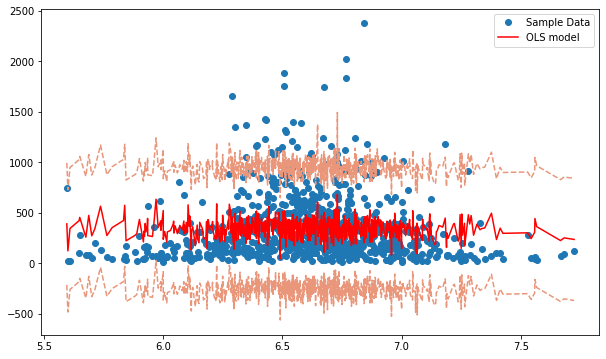

Residual Tests:
DW test statistic:  1.4387869672003133
(2: no serial correlation; 0: positive serial correlation; 4: negative serial correlation)


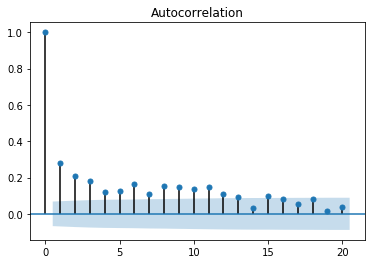

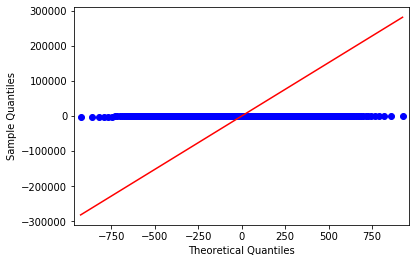

In [18]:
reg_col = ['MONTH', 'HOUR', 'Lat', 'Long']
lr = linear_regression()
lr.ols_fit(reg_data[reg_col], reg_data.NUM, add_const=True, plot='MONTH', assumption_test=True)

In [35]:
lr.get_confidence_intervals(alpha=0.05)

array([[-6688.86851222, 24609.78528092],
       [  -66.15022604,    44.68476785],
       [   41.40918808,    97.63172242],
       [  877.64325147,  1733.43837415],
       [  632.64866695,  1187.50531128]])

In [19]:
lr.gls_fit(reg_data[reg_col], reg_data.NUM, add_const=True)

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            GLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     15.04
Date:                Thu, 19 Sep 2019   Prob (F-statistic):           7.12e-12
Time:                        00:40:21   Log-Likelihood:                -5981.4
No. Observations:                 838   AIC:                         1.197e+04
Df Residuals:                     833   BIC:                         1.200e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8960.4584   7972.896      1.124      0.2

In [93]:
lr = linear_regression()
reg_col = ['OCCURRED_ON_DATE', 'OFFENSE_DESCRIPTION', 'MONTH', 'HOUR', 'Lat','OFFENSE_CODE']
lr.panel_regression(crime[reg_col], crime.Long, 'OFFENSE_DESCRIPTION', 'OCCURRED_ON_DATE', entity_effects=False, time_effects=False, other_effects=None)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   Long   R-squared:                        0.9996
Estimator:                   PanelOLS   R-squared (Between):              0.9993
No. Observations:              299074   R-squared (Within):               0.9996
Date:                Fri, Sep 13 2019   R-squared (Overall):              0.9996
Time:                        01:05:53   Log-likelihood                 3.791e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.966e+08
Entities:                         239   P-value                           0.0000
Avg Obs:                       1251.4   Distribution:                F(4,299069)
Min Obs:                       1.0000                                           
Max Obs:                    1.807e+04   F-statistic (robust):          1.966e+08
                            

Dep. Variable:,Long,R-squared:,0.9996
Estimator:,PanelOLS,R-squared (Between):,0.9993
No. Observations:,299074,R-squared (Within):,0.9996
Date:,"Fri, Sep 13 2019",R-squared (Overall):,0.9996
Time:,01:05:53,Log-likelihood,3.791e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.966e+08
Entities:,239,P-value,0.0000
Avg Obs:,1251.4,Distribution:,"F(4,299069)"
Min Obs:,1.0000,,
Max Obs:,1.807e+04,F-statistic (robust):,1.966e+08


In [17]:
reg_col = ['MONTH', 'HOUR', 'Lat', 'Long']
lr = linear_regression()
lr.glm_regression(reg_data[reg_col], reg_data.NUM, mod_family=sm.families.Gamma()).summary().as_latex()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    NUM   No. Observations:                  838
Model:                            GLM   Df Residuals:                      833
Model Family:                   Gamma   Df Model:                            4
Link Function:          inverse_power   Scale:                         0.77017
Method:                          IRLS   Log-Likelihood:                -5773.5
Date:                Thu, 19 Sep 2019   Deviance:                       763.98
Time:                        00:40:10   Pearson chi2:                     642.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0931      0.008    -11.567      0.0

C:\Users\cuixu\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


'\\begin{center}\n\\begin{tabular}{lclc}\n\\toprule\n\\textbf{Dep. Variable:}  &       NUM        & \\textbf{  No. Observations:  } &      838    \\\\\n\\textbf{Model:}          &       GLM        & \\textbf{  Df Residuals:      } &      833    \\\\\n\\textbf{Model Family:}   &      Gamma       & \\textbf{  Df Model:          } &        4    \\\\\n\\textbf{Link Function:}  &  inverse\\_power  & \\textbf{  Scale:             } &   0.77017   \\\\\n\\textbf{Method:}         &       IRLS       & \\textbf{  Log-Likelihood:    } &   -5773.5   \\\\\n\\textbf{Date:}           & Thu, 19 Sep 2019 & \\textbf{  Deviance:          } &    763.98   \\\\\n\\textbf{Time:}           &     00:40:10     & \\textbf{  Pearson chi2:      } &     642.    \\\\\n\\textbf{No. Iterations:} &        8         & \\textbf{                     } &             \\\\\n\\bottomrule\n\\end{tabular}\n\\begin{tabular}{lcccccc}\n               & \\textbf{coef} & \\textbf{std err} & \\textbf{z} & \\textbf{P$> |$z$|$} & \\text

## Sample: Logistic regression

In [112]:
reg_data['HIGH'] = (reg_data['NUM'] >= reg_data['NUM'].mean()).astype('int')

         Current function value: 0.633910
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
                           Logit Regression Results                           
Dep. Variable:                   HIGH   No. Observations:                  838
Model:                          Logit   Df Residuals:                      833
Method:                           MLE   Df Model:                            4
Date:                Fri, 13 Sep 2019   Pseudo R-squ.:                 0.03608
Time:                        01:00:39   Log-Likelihood:                -531.22
converged:                      False   LL-Null:                       -551.10
                                        LLR p-value:                 4.848e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1508     39.640      0.004      0.997     -77.543      77.8

C:\Users\cuixu\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<Figure size 432x288 with 0 Axes>

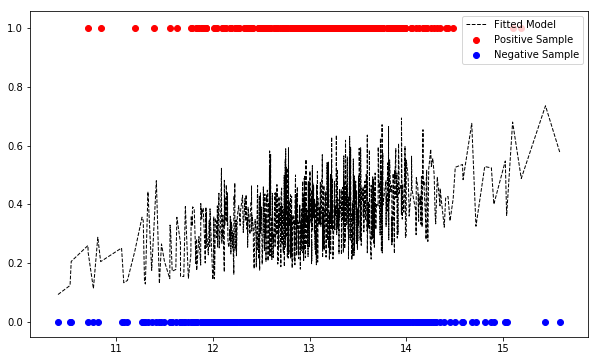

In [86]:
reg_col = ['MONTH', 'HOUR', 'Long', 'Lat']
lor = logistic_regression()
lor.fit(reg_data[reg_col],reg_data.HIGH, plot='HOUR')

Optimization terminated successfully.
         Current function value: 0.657611
         Iterations: 14
         Function evaluations: 18
         Gradient evaluations: 18
                           Logit Regression Results                           
Dep. Variable:                   HIGH   No. Observations:                  838
Model:                          Logit   Df Residuals:                      836
Method:                           MLE   Df Model:                            1
Date:                Fri, 13 Sep 2019   Pseudo R-squ.:               3.511e-05
Time:                        01:10:57   Log-Likelihood:                -551.08
converged:                       True   LL-Null:                       -551.10
                                        LLR p-value:                    0.8440
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2557      1.461     -

<Figure size 432x288 with 0 Axes>

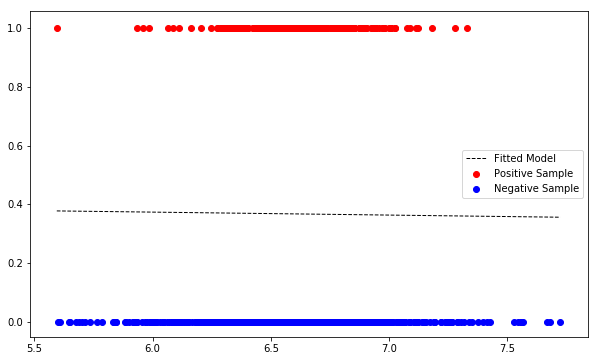

In [113]:
reg_col = ['MONTH']
lor = logistic_regression()
lor.fit(reg_data[reg_col],reg_data.HIGH, plot='MONTH')

         Current function value: 0.001724
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:                    FIT   No. Observations:                  838
Model:                          Logit   Df Residuals:                      836
Method:                           MLE   Df Model:                            1
Date:                Fri, 13 Sep 2019   Pseudo R-squ.:                  0.9975
Time:                        01:09:19   Log-Likelihood:                -1.4445
converged:                      False   LL-Null:                       -580.62
                                        LLR p-value:                6.878e-254
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.486e+04   1.27e+04     -1.174      0.240   -3.97e+04    9946.5

C:\Users\cuixu\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<Figure size 432x288 with 0 Axes>

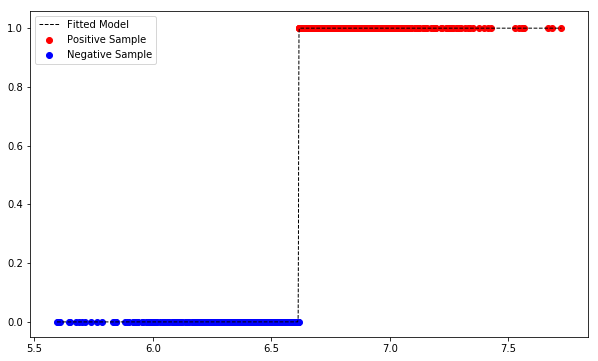

In [109]:
reg_data['FIT'] = (reg_data['MONTH'] >= reg_data['MONTH'].mean()).astype('int')
reg_col = ['MONTH']
lor = logistic_regression()
lor.fit(reg_data[reg_col],reg_data.FIT, plot='MONTH')

Precision:  1.0
Recall:  1.0
Accuracy:  1.0
F-measure:  1.0


<Figure size 432x288 with 0 Axes>

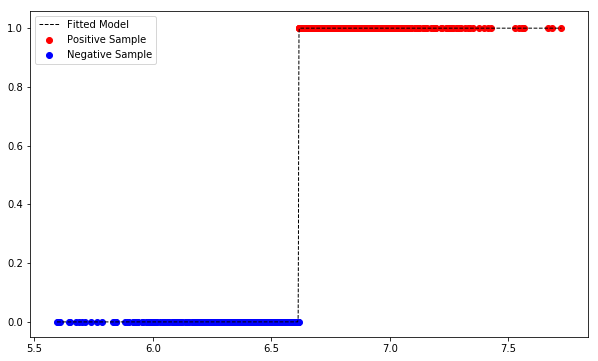

In [106]:
lor.test_performance(reg_data[reg_col],reg_data.FIT, plot='MONTH')

In [111]:
print(lor.get_coefficients())
print(lor.get_confidence_intervals())
print(lor.print_latex())
print(lor.get_r_square())

const   -14855.200
MONTH     2245.849
dtype: float64
               0         1
const -39656.984  9946.584
MONTH  -1503.765  5995.462
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       FIT        & \textbf{  No. Observations:  } &      838    \\
\textbf{Model:}         &      Logit       & \textbf{  Df Residuals:      } &      836    \\
\textbf{Method:}        &       MLE        & \textbf{  Df Model:          } &        1    \\
\textbf{Date:}          & Fri, 13 Sep 2019 & \textbf{  Pseudo R-squ.:     } &   0.9975    \\
\textbf{Time:}          &     01:10:23     & \textbf{  Log-Likelihood:    } &   -1.4445   \\
\textbf{converged:}     &      False       & \textbf{  LL-Null:           } &   -580.62   \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
               & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$>$$|$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const} &   -1.486e+04  &     1.27e+04     &    -1.174  &         0.2